<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

На анализ представлена информация клиентов «Бета-Банка».    
Среди представленных данных имеется информация о наличии факта ухода клиента из банка.   
Требуется проанализировать поведение клиентов и на основании этих данных спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.    
План действий:
- изучить предоставленный файл;
- подготовить данные к обучению;
- обучить несколько моделей, посчитать F1-меру;
- учесть дисбаланс классов, повторно обучить модели, посмотреть показатель AUC-ROC.

Целевой показатель - довести F1-меру до 0.59.    
Для начала импортируем библиотеки:

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv('Churn.csv')#Читаем файл с данными
data.info()#Посмотрим общую информацию о датафрейме
data.head()#Выведем первые строки датафрейма

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем название столбцов к нижнему регистру:

In [3]:
data.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', \
                'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

Найдем явные дубликаты:

In [4]:
data.duplicated().sum()

0

Явные дубликаты в датафрейме не обнаружены, посмотрим отдельно на имеющиеся данные по каждому столбцу. Для этого для числовых значений напишем функцию:

In [5]:
def describe_info (data, column, name_table_boxplot, name_x, name_table_hist, name_y):
    seaborn.boxplot(x=data[column])#Строим диаграмму размаха
    plt.title(name_table_boxplot)#Название диаграммы размаха
    plt.xlabel(name_x)#Подпись оси X
    plt.show()
    data[column].hist(bins = 50, figsize=(15, 5))#Строим гистограмму, количество корзин указываем 50
    plt.title(name_table_hist)#Название гистограммы
    plt.xlabel(name_x)#Подпись оси X
    plt.ylabel(name_y)#Подпись оси Y
    plt.show()
    print(f'Общая информация:\n{data[column].describe()}')#Выводим общую информацию методом describe

По столбцам *'row_number'* и *'customer_id'* данная функция не применима. По столбцу *'row_number'* должно быть 10 тыс. уникальных записей, начиная с 1, так как это индексы строк. Проверим эту информацию.

In [6]:
print(f'Минимальное значение: {data["row_number"].min()}\nМаксимальное значение: {data["row_number"].max()}\
\nКоличество уникальных значений: {data["row_number"].nunique()}')

Минимальное значение: 1
Максимальное значение: 10000
Количество уникальных значений: 10000


Теперь проверим данные по столбцу *'customer_id'*. Для нас главное, чтобы у каждой записи (каждого уникального клиента) был свой уникальный id:

In [7]:
data['customer_id'].duplicated().sum()

0

Для столбца *'surname'* наличие дубликатов естественно, пропусков нет, поэтому для предобработки всего лишь приведем столбец к нижнему регистру.

In [8]:
data['surname'] = data['surname'].str.lower()

Проанализируем столбец с кредитным рейтингом *'credit_score'*:

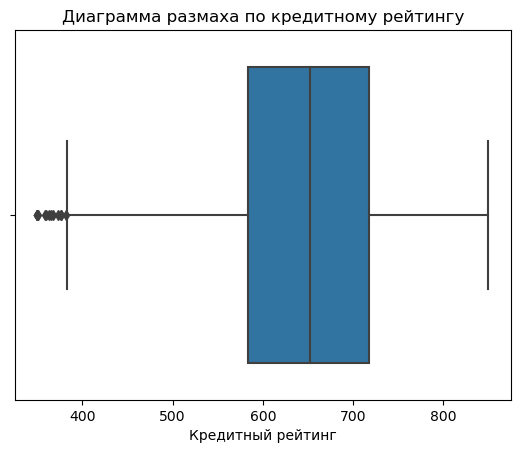

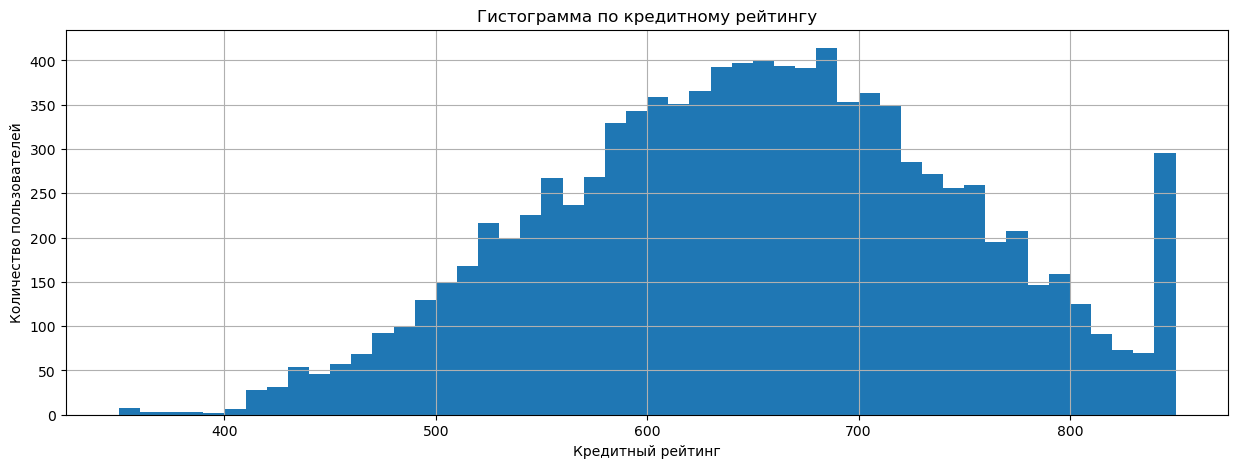

Общая информация:
count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64


In [9]:
describe_info(data, 'credit_score', 'Диаграмма размаха по кредитному рейтингу', 'Кредитный рейтинг', \
              'Гистограмма по кредитному рейтингу', 'Количество пользователей')

Можем заметить, что среднее значение кредитного рейтинга 651, досаточно большое количество записей с максимальным значением кредитного рейтинга 850 (или близким к нему), кроме того есть небольшое количество записей за пределами так называемого "левого уса", посчитаем их количество.

In [10]:
stat = data['credit_score'].describe()#Новая переменная нужна для определения границы усов
if stat[4] - 1.5*(stat[6] - stat[4]) < stat[3]:#Определяем левый ус
    left_whisk = stat[3]#Левый ус не может быть меньше минимального значения
else:
    left_whisk = stat[4] - 1.5*(stat[6] - stat[4])
#Посчитаем количество аномальных значений
print(f'Аномальных значений (меньше рейтинга {left_whisk}):\
{data.loc[(data["credit_score"] < left_whisk), "credit_score"].count()}')

Аномальных значений (меньше рейтинга 383.0):15


Всего 15 значений, выходящих за пределы "левого уса". Рейтинг у таких клиентов, исходя из "диаграммы размаха", неотрицательный, но система определения рейтинга "Бета-Банка" нам неизвеста, поэтому избавляться от этих данных не будем.     
Проанализируем столбец *'geography'*. Сначала приведем все данные к нижнему регистру (на случай разных записей), а потом построим круговую диаграмму:

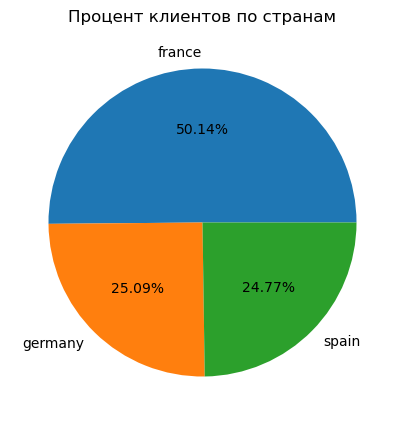

In [11]:
data['geography'] = data['geography'].str.lower()
data['geography'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(15, 5))
plt.title('Процент клиентов по странам')#Название диаграммы
plt.ylabel('')#Подпись оси Y
plt.show()

Можем заметить, что половина пользователей с Франции и по четверти с Германии и Испании.    
Посмотрим на столбец по гендеру, опять же приведем к нижнему регистру и построим круговую диаграмму:

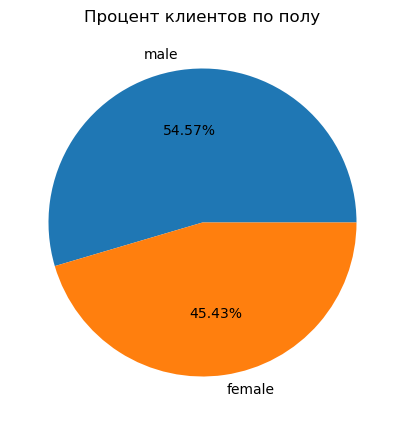

In [12]:
data['gender'] = data['gender'].str.lower()
data['gender'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5))
plt.title('Процент клиентов по полу')#Название диаграммы
plt.ylabel('')#Подпись оси Y
plt.show()

Можем заметить, что мужчин среди клиентов банка 55%, женщин 45%.    
Проанализируем пользователей по возрасту:

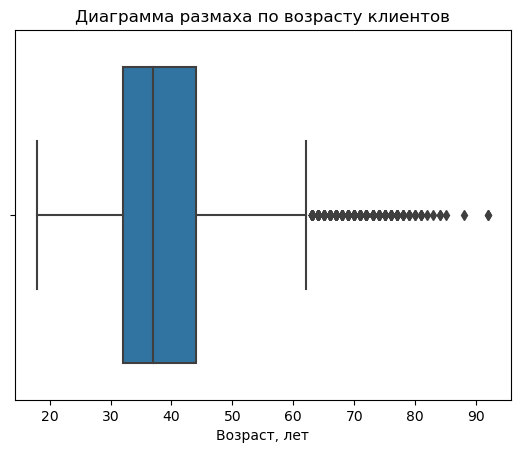

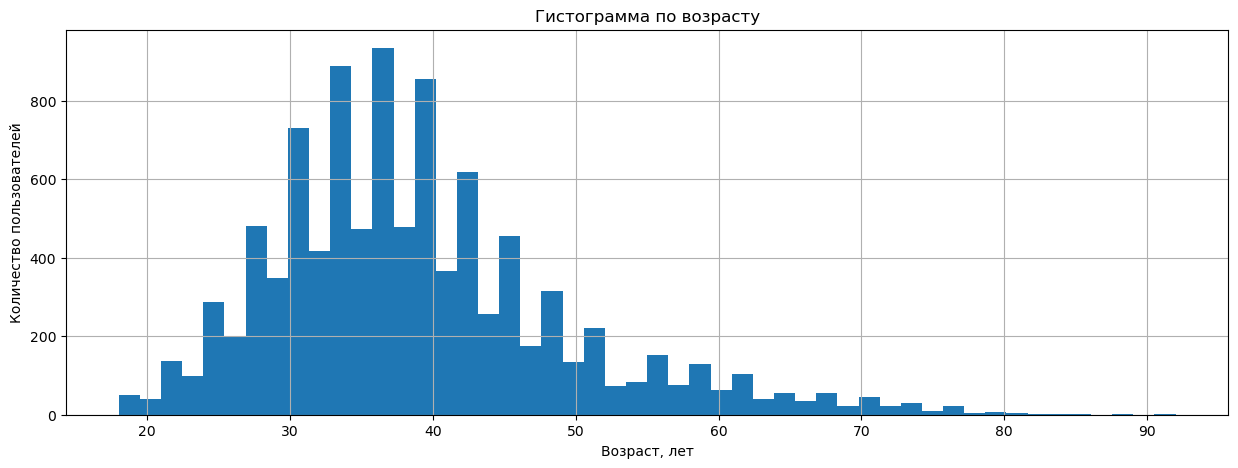

Общая информация:
count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


In [13]:
describe_info(data, 'age', 'Диаграмма размаха по возрасту клиентов', 'Возраст, лет', 'Гистограмма по возрасту', \
              'Количество пользователей')

Возраст клиентов варьируется с 18 до 92 лет. Средний возраст клиентов - примерно 39 лет.    
Расчитаем количество аномальных значений за пределами "правого уса":

In [14]:
stat = data['age'].describe()#Новая переменная нужна для определения границы усов
if stat[6] + 1.5*(stat[6] - stat[4]) > stat[7]:#Определяем правый ус
    right_whisk = stat[6]#Правый ус не может быть больше максимального значения
else:
    right_whisk = stat[6] + 1.5*(stat[6] - stat[4])
#Посчитаем количество аномальных значений
print(f'Аномальных значений (больше {right_whisk} лет): {data.loc[(data["age"] > right_whisk), "age"].count()}')

Аномальных значений (больше 62.0 лет): 359


Имеется 359 записей с возрастом более 62 лет (примерно 3,6% от общего числа). Оставляем их в датафрейме, так как среди клиентов банка могут быть и такие долгожители.    
Посмотрим на столбец *'tenure'*. У нас есть информация, что в столбце есть пропущенные значения. Причина отсутствия данных нам неизвестна, поэтому постараемся заполнить медианным значением.

In [15]:
data.loc[data['tenure'].isna(), 'tenure'] = data['tenure'].median()
data['tenure'].value_counts()#И посчитаем количество уникальных значений

5.0     1836
1.0      952
2.0      950
8.0      933
3.0      928
7.0      925
4.0      885
9.0      882
6.0      881
10.0     446
0.0      382
Name: tenure, dtype: int64

Также можем заметить, что тип столбца *'float'*, а не *'int'*, приведем в соответствие, а затем для наглядности построим диаграмму:

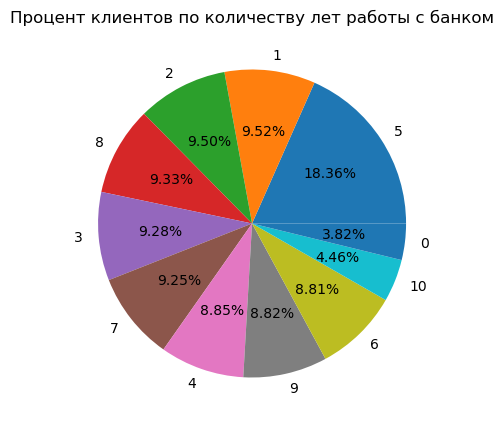

In [16]:
data['tenure'] = data['tenure'].astype('int')
data['tenure'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5))
plt.title('Процент клиентов по количеству лет работы с банком')#Название диаграммы
plt.ylabel('')#Подпись оси Y
plt.show()

Количество клиентов по сроку взаимодействия с банком распределено примерно равномерно по каждому году (по 8,8% - 9,5% от общего числа пользователей). Исключения составляют новые пользователи и клиенты, которые в банке уже 10 лет (таковых 3,8% и 4,5% соответственно). Так как пропуски заполняли медианным значением, то число клиентов, которые в банке 5 лет, также выделяется относительно остальных - более 18%.    
Проанализируем остаток на счете у клиентов:

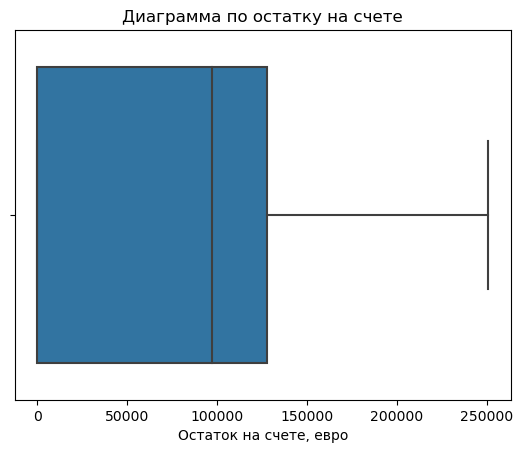

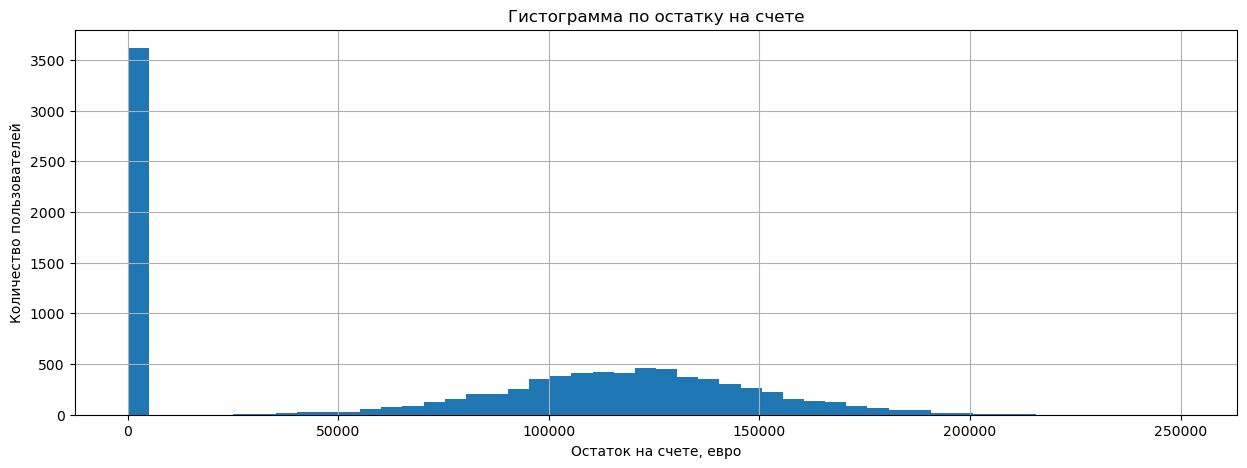

Общая информация:
count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


In [17]:
describe_info(data, 'balance', 'Диаграмма по остатку на счете', 'Остаток на счете, евро', 'Гистограмма по остатку на счете', \
              'Количество пользователей')
#Относительно денежных средств предполагаем валюту Евро, так как клиенты банка родом из Франции, Германии и Испании

Можем заметить, что остаток на счете составляет от 0 до почти 251 тыс.евро. Среднее значение 76,5 тыс.евро., медианное чуть менее 100 тыс.евро. Имеется большое число пользователей, у которых остаток ноль (более 3,5 тыс. записей). 
Возможно, это клиенты, покинувшие банк. Проверим это:

In [18]:
data.query('balance == 0 & exited == 1').shape[0]#Берем срез с нулевым балансом и признаком ухода из банка.
#А также цениваем размер среза и берем первую компоненту по количеству строк

500

Записей с нулевым балансом более 3500 записей, а ушедших из банка из них всего 500. Также среди возможных вариантов причин нулевого баланса клиентов вероятно, что на карту "Бета-Банка" клиенты получают зарплату, а затем переводят свои средства в другой банк с более лучшими условиями.    
Взглянем на столбец *'num_of_products'*:

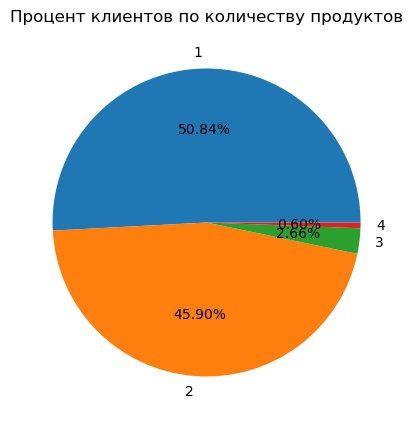

In [19]:
data['num_of_products'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5))
plt.title('Процент клиентов по количеству продуктов')#Название диаграммы
plt.ylabel('')#Подпись оси Y
plt.show()

Почти 97% клиентов пользуются всего 1 или 2 продуктами банками.    
Посмотрим на наличие кредитной карты:

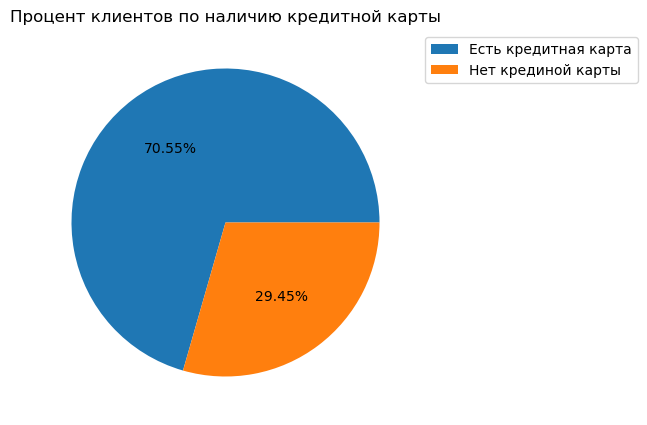

In [20]:
data['has_cr_card'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5), labels = None)
plt.title('Процент клиентов по наличию кредитной карты')#Название диаграммы
plt.legend(['Есть кредитная карта', 'Нет крединой карты'], bbox_to_anchor=(1, 1))
plt.ylabel('')#Подпись оси Y
plt.show()

Получается, у почти 71 пользователя есть кредитная карта, а пользователей с 2 продуктами и более всего около 49%. То есть, примерно у 21-22% пользователей из продуктов банка только кредитная карта. Это объясняет наличие большого количество записей с нулевым остатком, так как имеющийся остаток на кредитной карте ниже лимита - это средства банка, а не клиента.    
Посмотрим на активность клинтов:

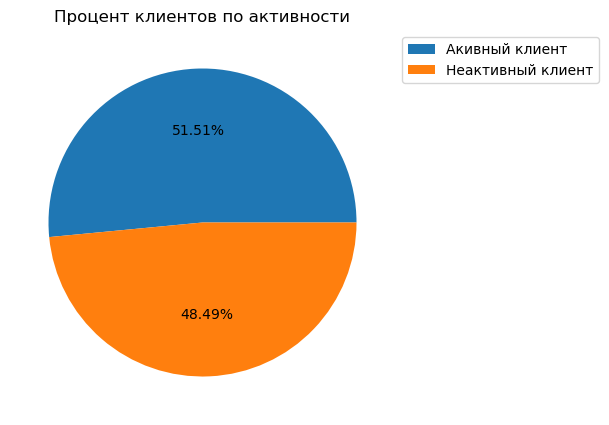

In [21]:
data['is_active_member'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5), labels = None)
plt.title('Процент клиентов по активности')#Название диаграммы
plt.legend(['Акивный клиент', 'Неактивный клиент'], bbox_to_anchor=(1, 1))
plt.ylabel('')#Подпись оси Y
plt.show()

У нас нет информации, каких клиентов "Бета-Банк" считает активными (например, пользуются ли клиенты продуктами банка за последнюю неделю/месяц и так далее). Но тот факт, что более 48% клиентов с точки зрения заказчика - неактивные клиенты, достаточно пессимистично.    
Посмотрим на предполагаемый доход:

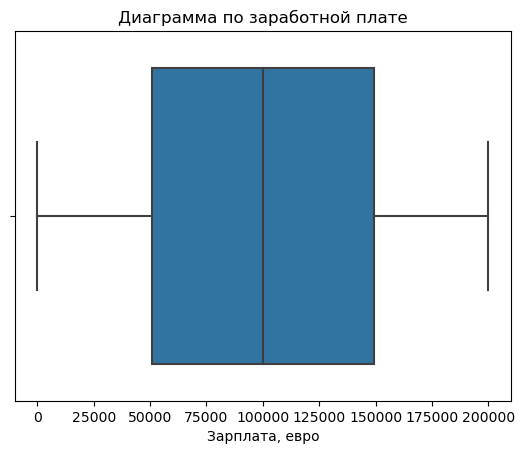

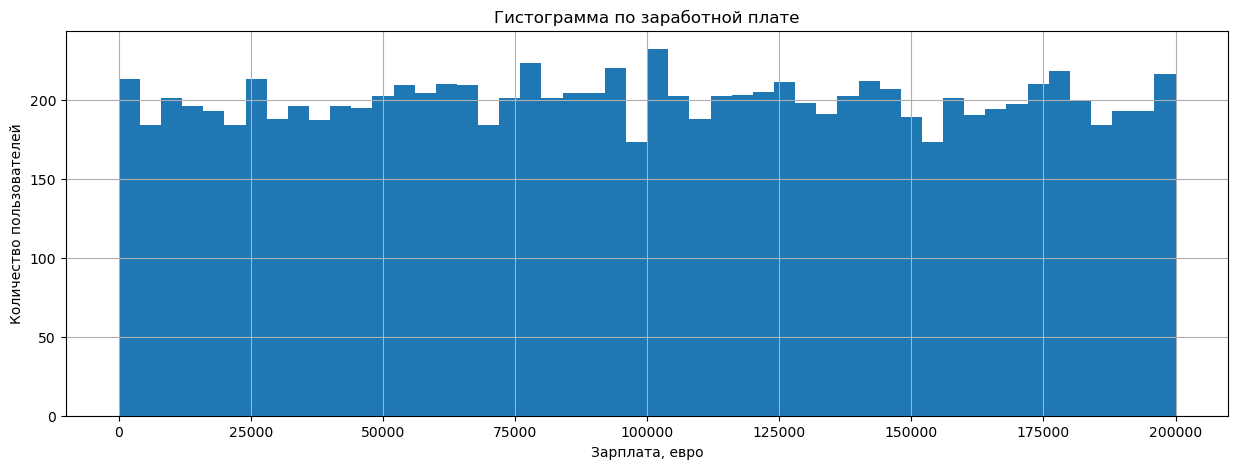

Общая информация:
count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64


In [22]:
describe_info(data, 'estimated_salary', 'Диаграмма по заработной плате', 'Зарплата, евро', \
              'Гистограмма по заработной плате', 'Количество пользователей')

Любопытно, гистограмма по предполагаемому доходу клиентов разбита на 50 корзин, но количество клиентов от корзины к корзине разнится незначительно, несмотря на то, что предполагаемая зарплата рассчитана от 11.5 евро до почти 200 тыс.евро.    
Также взглянем на процент ушедших клиентов:

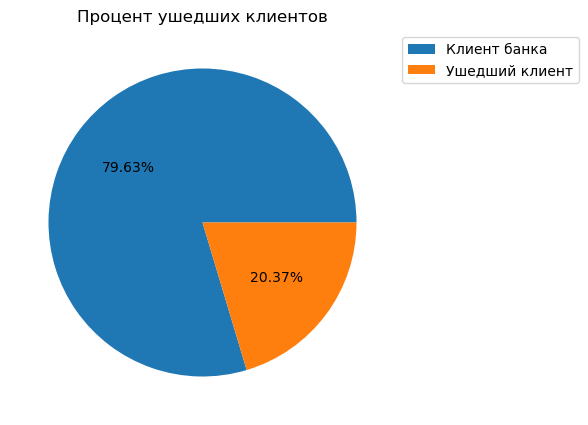

In [23]:
data['exited'].value_counts().plot(kind = 'pie', autopct='%.2f%%', figsize=(5, 5), labels = None)
plt.title('Процент ушедших клиентов')#Название диаграммы
plt.legend(['Клиент банка', 'Ушедший клиент'], bbox_to_anchor=(1, 1))
plt.ylabel('')#Подпись оси Y
plt.show()

Более 21% клиентов покинули банк, незавидная ситуация. Нужно выяснить будет ли это происходить в дальнейшем.   
Можем обратить внимание, что в датафрейме есть 3 столбца ("индекс строки в данных", "уникальный идентификатор клиента", "фамилия"), которые не оказывают влияние на уход клиента, поэтому избавимся от них.

In [24]:
data = data.drop(['row_number', 'customer_id', 'surname'], axis=1)#Удаляем столбцы, неинформативные для машинного обучения
data.info()#Проверим информацию, что столбцы удалены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int32  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int32(1), int64(6), object(2)
memory usage: 820.4+ KB


**Вывод по предоставленному файлу:**    
Представленный файл на анализ не имеет дубликатов.   
Пропушенные значения в столбце *'tenure'* заполнены медианными значениями и приведены к целочисленному формату. По полям типа *'string'* значения (как и названия столбцов) приведены к нижнему регистру.    
Аномальные значения по возрасту и кредитному рейтингу, выходящие, так сказать, за пределы "усов", решено оставить, поскольку формирования значений кредитного рейтинга нам неизвестны, а возраст клиентов находится в диапозоне допустимых значений.    
Отдельно стоит отметить некоторые интересные наблюдения:
- выявлено большое число пользователей с макисмальным кредитным рейтингом (около 300 чеовек);
- выявлено более 3500 записей с нулевым остатком на счете;
- 97% пользователей пользуются не более, чем 2 продуктами банка;
- почти половина клиентов - неактивные пользователи;
- доход и продолжительность взаимодействия клиента с банком распределены по большей части равномерно;
- почти 71% клиентов имеют в наличии кредитную карту "Бета-Банка";
- более 20% пользователей из представленного файла покинули банк.

Дополнительно из датафрейма удалены столбцы *'row_number'*, *'customer_id'*, *'surname'*, которые не влияют на уход клиента из банка.

## Исследование задачи

В имеющемся файле у нас имеется 2 категориальные переменные:
- Страна;
- Пол.

Прежде, чем применять к ним технологию *OHE*, разделим данные на тестовую, валидационную и обучающие выборки:

In [25]:
#Для деления на три выборки необходимо 'train_test_split' вызвать 2 раза:
#Сначала выделим обучающую выборку на 60%, остальное разделим позже
random_state_12345 = 12345#Сохраним переменную со значением random_state
target = data['exited']#Целевой показатель
features = data.drop('exited', axis=1)
features_train, features_df, target_train, target_df = train_test_split(features, target, test_size=0.4, \
                                                                        random_state=random_state_12345, stratify = None)
#Оставшиеся 40% разделим на тестовую и валидационную выборки
features_valid, features_test, target_valid, target_test = train_test_split(features_df, target_df, test_size=0.5, \
                                                                            random_state=random_state_12345, stratify = None)
#Проверим размер выборок:
print(f'Размер обучающей выборки: {round(features_train.shape[0]*100/features.shape[0], 2)}%')
print(f'Размер валидационной выборки: {round(features_valid.shape[0]*100/features.shape[0], 2)}%')
print(f'Размер тестовой выборки: {round(features_test.shape[0]*100/features.shape[0], 2)}%')

Размер обучающей выборки: 60.0%
Размер валидационной выборки: 20.0%
Размер тестовой выборки: 20.0%


Применим *OHE* к обучающей выборке: 

In [26]:
cat_features = ['geography', 'gender']#Записываеем старые признаки
ohe = OneHotEncoder(drop='first', sparse=False)#Сохраняем технологию OHE
train_temp = ohe.fit_transform(features_train[cat_features])#Обучаем и применяем OHE на обучающей выборке
pd.options.mode.chained_assignment = None#Игнорируем возможные предупреждения
features_train[ohe.get_feature_names_out()] = train_temp#Вписываем новые признаки
features_train.drop(cat_features, axis=1, inplace=True)#Удаляем старые признаки
features_train.head()#Посмотрим, как OHE отработала

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7479,567,35,8,153137.74,1,1,0,88659.07,0.0,1.0,1.0
3411,711,37,8,113899.92,1,0,0,80215.20,0.0,0.0,0.0
6027,850,44,3,140393.65,2,0,1,186285.52,1.0,0.0,1.0
1247,512,24,6,0.00,2,1,0,37654.31,0.0,0.0,1.0
3716,665,27,2,147435.96,1,0,0,187508.06,1.0,0.0,0.0


Чтобы не было дамми-ловушки, при трансформации признаков мы удаляли по одному из столбцов каждого из базовых признаков ("страны" и "пола"), поскольку удаленные столбцы можно восстановить по оставшимся. Теперь применим *OHE* к оставшимся выборкам:

In [27]:
valid_temp = ohe.fit_transform(features_valid[cat_features])#Обучаем и применяем OHE на валидационной выборке
pd.options.mode.chained_assignment = None#Игнорируем возможные предупреждения
features_valid[ohe.get_feature_names_out()] = valid_temp#Вписываем новые признаки
features_valid.drop(cat_features, axis=1, inplace=True)#Удаляем старые признаки
features_valid.head()#Посмотрим, как OHE отработала

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
8532,585,35,2,0.00,2,1,0,98621.04,0.0,0.0,0.0
5799,625,45,3,0.00,1,1,1,184474.15,0.0,0.0,0.0
5511,667,32,0,103846.65,1,1,0,20560.69,1.0,0.0,1.0
7365,568,36,10,153610.61,1,1,1,54083.80,0.0,1.0,0.0
7367,606,42,10,0.00,2,1,0,177938.52,0.0,1.0,1.0


И, соответственно, применяем к тестовой выборке:

In [28]:
test_temp = ohe.fit_transform(features_test[cat_features])#Обучаем и применяем OHE на тестовой выборке
pd.options.mode.chained_assignment = None#Игнорируем возможные предупреждения
features_test[ohe.get_feature_names_out()] = test_temp#Вписываем новые признаки
features_test.drop(cat_features, axis=1, inplace=True)#Удаляем старые признаки
features_test.head()#Посмотрим, как OHE отработала

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7041,438,38,2,0.00,2,1,0,136859.55,0.0,0.0,1.0
5709,644,39,9,0.00,1,1,0,3740.93,0.0,0.0,0.0
7117,564,31,5,121461.87,1,1,1,20432.09,0.0,1.0,1.0
7775,628,40,10,0.00,2,1,0,103832.58,0.0,1.0,1.0
8735,728,30,10,114835.43,1,0,1,37662.49,0.0,0.0,1.0


Определяем лучшую модель "Решающего дерева":

In [29]:
best_model_tree = None#Определим лучшую модель по глубине дерева
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меры
for depth in range(1, 11):#Попробуем изменять глубину дерева
    model = DecisionTreeClassifier(random_state=random_state_12345, max_depth=depth)#Определяем модель с разной глубиной дерева
    model.fit(features_train, target_train)#Обучаем модель
    predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
    result = f1_score(target_valid, predicted_valid)#Считаем F1-меру
    if result > best_f1:#Определяем лучшую модель "Решающего дерева"
        best_model_tree = model
        best_depth = depth
        best_f1 = result
print(f'Лучшая модель: {best_model_tree}\nЛучшая глубина дерева: {best_depth}\nЛучший показатель F1-меры: {best_f1.round(3)}')

Лучшая модель: DecisionTreeClassifier(max_depth=6, random_state=12345)
Лучшая глубина дерева: 6
Лучший показатель F1-меры: 0.57


"Решающее дерево" с глубиной 6 достигает F1-меры в 0.57, довольно нелохо.    
Взглянем, как предсказывает данная модель на матрице ошибок:

In [30]:
model = best_model_tree#Используем лучшую модель с заданной глубиной дерева
model.fit(features_train, target_train)#Обучаем модель
predicted_valid = model.predict(features_valid)
print(confusion_matrix(target_valid, predicted_valid))

[[1528   54]
 [ 230  188]]


Видно, что модель "Решающего дерева" предсказала ложноотрицательных ответов больше, чем истинноположительных.    
Посмотрим на показатель AUC-ROC:

Показатель AUC-ROC "Решающего дерева": 0.816


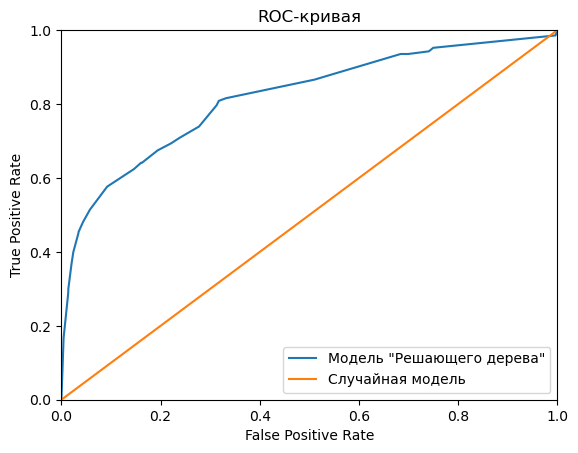

In [31]:
probabilities_valid = model.predict_proba(features_valid)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Решающего дерева": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Решающего дерева"')#Рисуем ROC-кривую "Решающего дерева"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

Видим, что, несмотря на недостижение целевого показателя F1-меры в 0.59, модель "Решающего дерева" предсказывает значительно лучше, чем случайная модель.    
Посмотрим, как работает модель "Логистической регрессии". Но для начала масштабируем признаки, поскольку они имеют абсолютно разные диапозоны значений, но при этом важны все:

In [32]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_standart = scaler.transform(features_train)
features_valid_standart = scaler.transform(features_valid)
features_test_standart = scaler.transform(features_test)

Применим модель "Логистической регрессии":

In [33]:
model = LogisticRegression(random_state=random_state_12345)
model.fit(features_train_standart, target_train)
predicted_valid = model.predict(features_valid_standart)
print(f'Показатель F1-меры: {f1_score(target_valid, predicted_valid).round(3)}')

Показатель F1-меры: 0.331


А вот тут показатель F1-меры равен всего 0.331, это неудовлетворительно. Псмотрим, что покажет матрица ошибок:

In [34]:
print(confusion_matrix(target_valid, predicted_valid))

[[1506   76]
 [ 320   98]]


Модель "Логистической регрессии" предсказывает ложноотрицательных ответов в 3.2 раза больше, чем истинноположительных. Нужно будет улучшать модель. Сравним с показателем AUC-ROC:

Показатель AUC-ROC "Логистической регессии": 0.759


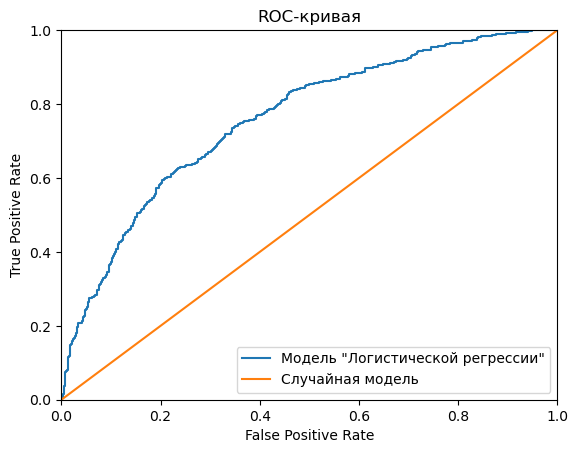

In [35]:
probabilities_valid = model.predict_proba(features_valid_standart)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Логистической регессии": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Логистической регрессии"')#Рисуем ROC-кривую "Логистической регрессии"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

F1-мера на модели "Логистической регрессии" получилась достаточно низкой (0.331), но вот показатель AUC-ROC демонстрирует результат значительно лучше случайной модели (0.759 против 0.5).    
Посмотрим на модель "Случайного леса":

In [36]:
best_model_forest = None#Определим лучшую модель "Случайного леса"
best_est = 0#В указанную переменную запишем наилучшее количество деревьев
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меры
for est in range(1, 101, 5):#Зададим количество деревьев от 1 до 100 с шагом 5
    for depth in range (1, 11):#Зададим глубину дерева от 1 до 10
        model = RandomForestClassifier(random_state=random_state_12345, n_estimators=est, max_depth=depth)
        #Инициализируем модель "Случайного леса"
        model.fit(features_train, target_train)#Обучаем модель на тренировочной выборке
        predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
        result = f1_score(target_valid, predicted_valid)#Рассчитываем F1-меру
        if result > best_f1:#Определяем лучшую модель "Случайного леса"
            best_model_forest = model
            best_est = est
            best_depth = depth
            best_f1 = result
print(f'Лучшая модель: {best_model_forest}\nНаилучшее количество деревьев: {best_est}\nЛучшая глубина дерева: {best_depth}\
\nЛучший показатель F1-меры: {best_f1.round(3)}')

Лучшая модель: RandomForestClassifier(max_depth=10, n_estimators=11, random_state=12345)
Наилучшее количество деревьев: 11
Лучшая глубина дерева: 10
Лучший показатель F1-меры: 0.59


"Случаный лес" с глубиной 10 и количеством деревьев, равных 11, достигает F1-меры в 0.59, наш целевой показатель.
Взглянем, как предсказывает данная модель на матрице ошибок:

In [37]:
model = best_model_forest#Используем лучшую модель с заданной глубиной дерева
model.fit(features_train, target_train)#Обучаем модель
predicted_valid = model.predict(features_valid)
print(confusion_matrix(target_valid, predicted_valid))

[[1532   50]
 [ 222  196]]


Обычное явление, как и по другим моделям, ложноотрицательных ответов получается больше, чем истинноположительных.   
Также посмотрим на AUC-ROC:

Показатель AUC-ROC "Случайного леса": 0.849


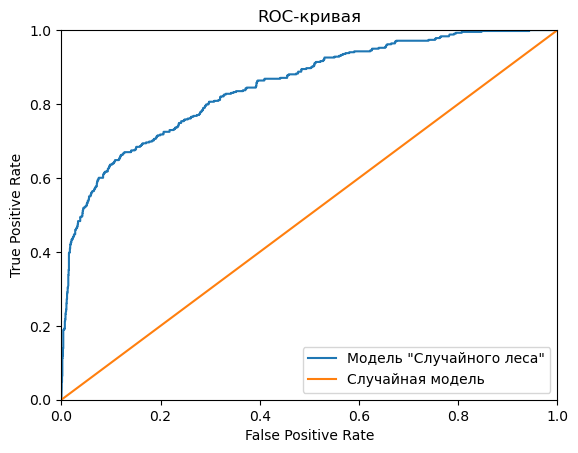

In [38]:
probabilities_valid = model.predict_proba(features_valid)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Случайного леса": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Случайного леса"')#Рисуем ROC-кривую "Случайного леса"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

Получили лучший вариант AUC-ROC среди трех моделей, F1-мера, напомню, тоже лучшая на модели "Случайного леса".

**Вывод по первичному исследованию:**    
Предоставленные данные были разделены на 3 выборки: 
- тестовая (20%);
- валидационная (20%);
- обучающая выборки (60%).

Категориальные переменные "страна" и "пол клиента" были преобразованы технологией *OHE*.

Был произведен поиск лучшей модели "Решающего дерева" с глубиной от 1 до 10 включительно. Лучшей моделью оказалось дерево с глубиной 6, показатель F1-меры составил 0.57, AUC-ROC равен 0.816. При этом матрица ошибок продемонстрировала, что модель часто предсказывает "0" там, где должен быть "1".   
Модель "Логистическая регрессия" дает результат F1-меры, равный 0.331, AUC-ROC равен 0.759, ложноотрицательные ответы данная модель предсказывает еще чаще, чем предыдущая. Также стоит отметить, что "Логистическая регрессия" обучалась на  масштабированных данных.    
Модель "Случайного леса" показала результат F1-меры 0.59 при глубине дерева 10 и 11-ти деревьях, AUC-ROC равен 0.849. Матрица ошибок показала наилучший результат среди представленных моделей, но ложноотрицательных ответов все так же больше, чем истинноположительных.

## Борьба с дисбалансом

Попробуем сбалансировать классы в модели "Логистической регрессии" и посмотрим, как изменится показатель F1-меры:

In [39]:
model = LogisticRegression(random_state=random_state_12345, class_weight = 'balanced')
model.fit(features_train_standart, target_train)
predicted_valid = model.predict(features_valid_standart)
print(f'Показатель F1-меры: {f1_score(target_valid, predicted_valid).round(3)}')

Показатель F1-меры: 0.489


F1-мера улучшилась, но еще далека от идеала, попробуем сбалансировать классы у "Решающего дерева":

In [40]:
best_model_tree = None#Определим лучшую модель по глубине дерева
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меру
for depth in range(1, 11):#Попробуем изменять глубину дерева
#Определяем модель с заданной глубиной дерева и балансируем классы:    
    model = DecisionTreeClassifier(random_state=random_state_12345, max_depth=depth, class_weight = 'balanced')
    model.fit(features_train, target_train)#Обучаем модель
    predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
    result = f1_score(target_valid, predicted_valid)#Считаем F1-меру
    if result > best_f1:#Определяем лучшую модель "Решающего дерева"
        best_model_tree = model
        best_depth = depth
        best_f1 = result
print(f'Лучшая модель: {best_model_tree}\nЛучшая глубина дерева: {best_depth}\nЛучший показатель F1-меры: {best_f1.round(3)}')

Лучшая модель: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
Лучшая глубина дерева: 5
Лучший показатель F1-меры: 0.596


При балансировке классов модель "Решающего дерева" смогла довести показатель F1-меры до 0.596 при глубине дерева, равной 5.    
Сбалансируем классы у "Случайного леса":

In [41]:
best_model_forest = None#Определим лучшую модель "Случайного леса"
best_est = 0#В указанную переменную запишем наилучшее количество деревьев
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меры
for est in range(1, 101, 5):#Зададим количество деревьев от 1 до 101 с шагом 5
    for depth in range (1, 11):#Зададим глубину дерева от 1 до 10
        model = RandomForestClassifier(random_state=random_state_12345, n_estimators=est, max_depth=depth, \
                                       class_weight = 'balanced')
        #Инициализируем модель 'случайного леса'
        model.fit(features_train, target_train)#Обучаем модель на тренировочной выборке
        predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
        result = f1_score(target_valid, predicted_valid)#Рассчитываем F1-меру
        if result > best_f1:#Определяем лучшую модель "Случайного леса"
            best_model_forest = model
            best_est = est
            best_depth = depth
            best_f1 = result
print(f'Лучшая модель: {best_model_forest}\nНаилучшее количество деревьев: {best_est}\nЛучшая глубина дерева: {best_depth}\
\nЛучший показатель F1-меры: {best_f1.round(3)}')

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=46,
                       random_state=12345)
Наилучшее количество деревьев: 46
Лучшая глубина дерева: 8
Лучший показатель F1-меры: 0.628


При балансировке классов модель "Случайного леса" смогла довести показатель F1-меры до 0.628, при этом гиперпараметры по количеству деревьев и глубине дерева изменились на 46 и 8 соответственно.   
Разделим обучающую выборку на отрицательные и положительные объекты, а затем постараемся их сбалансировать. Напишем функцию:

In [42]:
def upsample(features, target):
    features_zeros = features[target == 0]#Признаки объектов с целевым показателем "0"
    features_ones = features[target == 1]#Признаки объектов с целевым показателем "1"
    target_zeros = target[target == 0]#Целевой признак "0"
    target_ones = target[target == 1]#Целевой признак "1"
    #Выведем на экран размерности данных 4-ех переменных:
    print(f'features_zeros = {features_zeros.shape}\nfeatures_ones = {features_ones.shape}\
    \ntarget_zeros = {target_zeros.shape}\ntarget_ones = {target_ones.shape}')
    #Посчитаем во сколько раз нужно изменить кол-во ответов "1", чтобы их число было сопоставимым с ответами "0"
    repeat = (features_zeros.shape[0]/features_ones.shape[0])
    print(f'Во сколько раз нужно изменить обучающую выборку по положительным ответам: {int(repeat)}')
    features_upsampled = pd.concat([features_zeros] + [features_ones] * int(repeat))#Изменяем обучающую выборку
    target_upsampled = pd.concat([target_zeros] + [target_ones] * int(repeat))#Изменяем обучающую выборку по ответам
    #Теперь выборку нужно "перемешать" функцией 'shuffle'
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state_12345)
    return features_upsampled, target_upsampled

In [43]:
features_upsampled, target_upsampled = upsample(features_train, target_train)
print(f'Размерность увеличенной выборки: {features_upsampled.shape}\nРазмерность целевого показателя: {target_upsampled.shape}')

features_zeros = (4804, 11)
features_ones = (1196, 11)    
target_zeros = (4804,)
target_ones = (1196,)
Во сколько раз нужно изменить обучающую выборку по положительным ответам: 4
Размерность увеличенной выборки: (9588, 11)
Размерность целевого показателя: (9588,)


Можем заметить, что целевой показатель "1" встречается примерно в 4 раза реже, чем "0", поэтому функция увеличивает обучающую выборку в части положительных классов в 4 раза (итого выборка увеличивается с 6 тыс. значений до почти 9,6 тыс.значений). Для "Логистической регрессии" дополнительно масштабируем:

In [44]:
scaler.fit(features_train) 
features_upsampled_standart = scaler.transform(features_upsampled)

Попробуем найти наилучшую модель среди "Решающих деревьев" на увеличенной выборке:

In [45]:
best_model_tree = None#Определим лучшую модель по глубине дерева
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меру
for depth in range(1, 11):#Попробуем изменять глубину дерева
    model = DecisionTreeClassifier(random_state=random_state_12345, max_depth=depth)#Определяем модель с разной глубиной дерева
    model.fit(features_upsampled, target_upsampled)#Обучаем модель
    predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
    result = f1_score(target_valid, predicted_valid)#Считаем F1-меру
    if result > best_f1:#Определяем лучшую модель "Решающего дерева"
        best_model_tree = model
        best_depth = depth
        best_f1 = result
print(f'Лучшая модель увеличенной выборки: {best_model_tree}\nЛучшая глубина дерева: {best_depth}\nЛучший показатель F1-меры: \
{best_f1.round(3)}')

Лучшая модель увеличенной выборки: DecisionTreeClassifier(max_depth=5, random_state=12345)
Лучшая глубина дерева: 5
Лучший показатель F1-меры: 0.596


Показатель F1-меры остался таким же, как и при балансировки классов, 0.596.    
Взглянем на показатель AUC-ROC. Для сравнения, AUC-ROC случайной модели равна 0.5.

Показатель AUC-ROC "Решающего дерева": 0.831


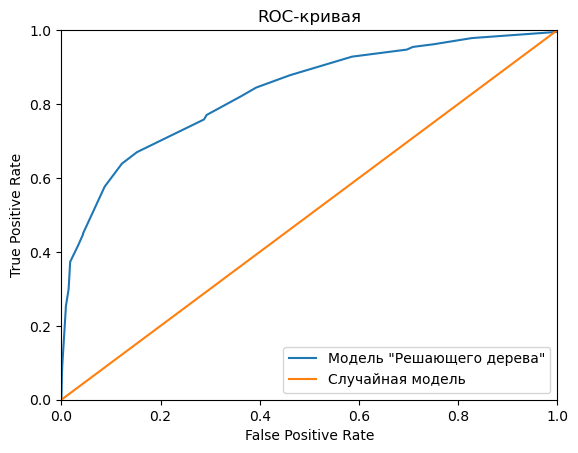

In [46]:
model = best_model_tree#Применяем лучшую модель"Решающего дерева" 
model.fit(features_upsampled, target_upsampled)#Обучаем модель
probabilities_valid = model.predict_proba(features_valid)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Решающего дерева": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Решающего дерева"')#Рисуем ROC-кривую "Решающего дерева"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

Получился показатель AUC-ROC, равный 0.831, что говорит о достаточной хорошей обучаемости относительно случайной модели.    
Теперь посмотрим, как себя поведет модель "Логистической регрессии" на увеличенной выборке:

In [47]:
model = LogisticRegression(random_state=random_state_12345)
model.fit(features_upsampled_standart, target_upsampled)#Обучаем модель на новой выборке
predicted_valid = model.predict(features_valid_standart)#Предсказываем на валидационной выборке
print(f'F1-мера модели "Логистическая регрессия" на увеличенной выборке: {f1_score(target_valid, predicted_valid).round(3)}')

F1-мера модели "Логистическая регрессия" на увеличенной выборке: 0.489


Увы, но увеличение выборки не смогло довести F1-меру на модели "Логистическая регессия" до целевого показателя.    
Сравним с показателем AUC-ROC, напомню, AUC-ROC случайной модели равна 0.5.

Показатель AUC-ROC "Логистической регессии": 0.764


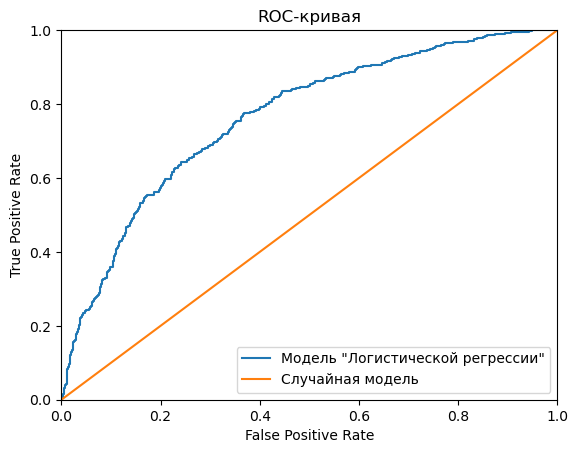

In [48]:
probabilities_valid = model.predict_proba(features_valid_standart)#Определяем вероятности функцией 'predict_proba'
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Логистической регессии": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Логистической регрессии"')#Рисуем ROC-кривую "Логистической регрессии"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

Опять же, несмотря на то, что модель "Логистическая регрессия" не достигла целевого показателя F1-меры, равного 0.59, показатель AUC-ROC "Логистической регрессии" демонстрирует, что предсказания данной модели в ~1,5 раза лучше, чем у случайной модели.    
Посмотрим на работу модели "Случайного леса" на увеличенной выборке:

In [49]:
best_model_forest = None#Определим лучшую модель "Случайного леса"
best_est = 0#В указанную переменную запишем наилучшее количество деревьев
best_depth = 0#В указанную переменную запишем наилучшую глубину дерева
best_f1 = 0#В указанную переменную запишем лучший показатель F1-меры
for est in range(1, 101, 5):#Зададим количество деревьев от 1 до 50 с шагом 5
    for depth in range (1, 11):#Зададим глубину дерева от 1 до 10
        model = RandomForestClassifier(random_state=random_state_12345, n_estimators=est, max_depth=depth)
        #Инициализируем модель 'случайного леса'
        model.fit(features_upsampled, target_upsampled)#Обучаем модель на увеличенной выборке
        predicted_valid = model.predict(features_valid)#Предсказываем на валидационной выборке
        result = f1_score(target_valid, predicted_valid)#Считаем F1-меру
        if result > best_f1:#Определяем лучшую модель "Случайного леса"
            best_model_forest = model
            best_est = est
            best_depth = depth
            best_f1 = result
print(f'Лучшая модель: {best_model_forest}\nНаилучшее количество деревьев: {best_est}\nЛучшая глубина дерева: {best_depth}\
\nЛучший показатель F1-меры: {best_f1.round(3)}')

Лучшая модель: RandomForestClassifier(max_depth=8, n_estimators=26, random_state=12345)
Наилучшее количество деревьев: 26
Лучшая глубина дерева: 8
Лучший показатель F1-меры: 0.629


Показатель F1-меры составил 0.629. Модель "Случайного леса" единственная смогла показать улучшение F1-меры на увеличенной выборке относительно модели с балансировкой классов, количество деревьев составило 26, глубина равна 8.    
Теперь посчитаем AUC-ROC:

Показатель AUC-ROC "Случайного леса": 0.854


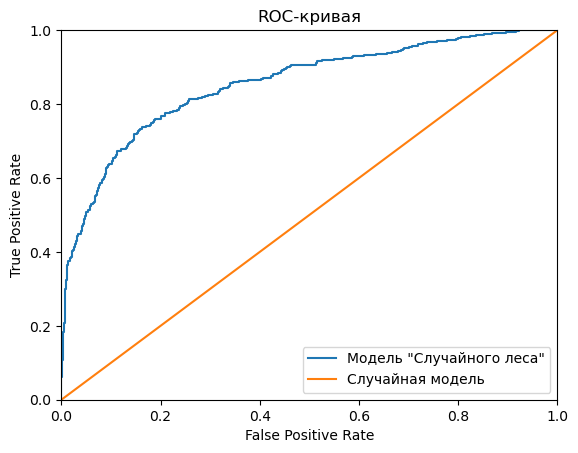

In [50]:
model = best_model_forest#Применяем лучшую модель"Случайного леса"
model.fit(features_upsampled, target_upsampled)#Обучаем модель
probabilities_valid = model.predict_proba(features_valid)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_valid = probabilities_valid[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Показатель AUC-ROC "Случайного леса": {auc_roc.round(3)}')#Выведем на экран показатель AUC-ROC
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Случайного леса"')#Рисуем ROC-кривую "Случайного леса"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

На максимальной F1-мере среди рассматриваемых моделей показатель AUC-ROC также максимальный (0.854).

**Вывод по борьбе с дисбалансом:**    
В рамках борьбы с дисбалансом использовалось 2 алгоритма:
- Использование параметра *class_weight* в применяемых моделях
- Увеличение обучающей выборки (в части положительных классов в 4 раза)

Указанные методы применялись на моделях "Решающего дерева", "Логистической регрессии" и "Случайного леса".    
"Логистической регрессии" не удалось достичь целевого показателя F1-меры в обоих случаях, но стоит отметить, что в рамках борьбы с дисбалансом F1-мера изменилась с 0.331 до 0.489.    
Модель "Решающего дерева" в обоих случаях смогла превысить целевой показатель F1-меры, равный 0.59.    
Модель "Случайного леса" смогла достичь наилучших показателей F1-меры. На увеличенной выборке показатель составил 0.629, количество деревьев 26, глубина дерева равна 8. 
AUC-ROC всех моделей продемонстрировал лучшую обучаемость относительно случайной модели.

## Тестирование модели

Теперь применим нашу лучшую модель к тестовой выборке ("Случайный лес" с глубиной 8 и клоичеством деревьев 26, обучение на увеличенной выборке), попутно выведя на экран показатели *AUC-ROC* и *F1-меры*:

Лучшая модель: RandomForestClassifier(max_depth=8, n_estimators=26, random_state=12345)
Показатель AUC-ROC "Случайного леса": 0.855
Показатель F1-меры: 0.609


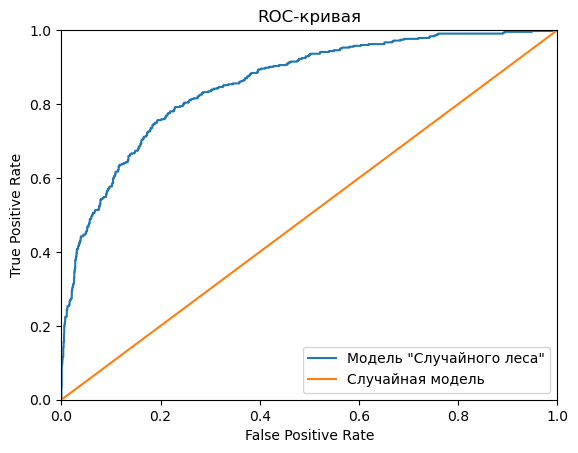

In [51]:
model = best_model_forest#Применяем лучшую модель"Случайного леса"
model.fit(features_upsampled, target_upsampled)#Обучаем модель
predicted_test = model.predict(features_test)#Делаем предсказания
probabilities_test = model.predict_proba(features_test)#Определяем вероятности функцией 'predict_proba' 
probabilities_one_test = probabilities_test[:, 1]#Сохраняем вероятности класса "1"
auc_roc = roc_auc_score(target_test, probabilities_one_test)#Посчитаем показатель AUC-ROC функцией 'roc_auc_score'
print(f'Лучшая модель: {best_model_forest}\nПоказатель AUC-ROC "Случайного леса": {auc_roc.round(3)}\n\
Показатель F1-меры: {f1_score(target_test, predicted_test).round(3)}')#Выведем на экран показатель AUC-ROC и F1-меры
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)#Применив функцию 'roc_curve', получаем FPR, TPR и пороги
plt.plot(fpr, tpr, label = 'Модель "Случайного леса"')#Рисуем ROC-кривую "Случайного леса"
x = [0, 1]#Указываем данные для ROC-кривой случайной модели (это прямая из [0,0] в [1,1])
plt.plot(x,x, label = 'Случайная модель')#Рисуем ROC-кривую случайной модели
plt.xlim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси абцисс
plt.ylim([0.0, 1.0])#Устанавливаем границы от 0 до 1 по оси ординат
plt.legend()#Выводим на экран легенду
plt.xlabel('False Positive Rate')#Подписываем ось абцисс как FPR
plt.ylabel('True Positive Rate')#Подписываем ось ординат как TPR
plt.title('ROC-кривая')#Даем название графику
plt.show()

Модель "Случайный лес" с глубиной 8 и количеством деревьев 26, обученная на увеличенной выборке, показывает хорошие результаты и на тестовой выборке. Показатель F1-меры составляет 0.609, а AUC-ROC 0.855.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

**Общий вывод:**   

На анализ представлена информация клиентов «Бета-Банка». Среди представленных данных имеется информация о наличии факта ухода клиента из банка. Требовалось проанализировать поведение клиентов и на основании этих данных спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.   
Целевой показатель - довести F1-меру до 0.59.

В представленном файле дубликатов не обнаружено.   
Пропушенные значения в столбце *'tenure'* были заполнены медианными значениями. По полям типа *'string'* значения (как и названия столбцов) приведены к нижнему регистру.    
Аномальные значения по возрасту и кредитному рейтингу, выходящие, так сказать, за пределы "усов" диаграммы "ящик с усами", решено оставить, поскольку формирования значений кредитного рейтинга нам неизвестны, а возраст клиентов находится в диапозоне допустимых значений.    

Предоставленные данные были разделены на 3 выборки: 
- тестовая (20%);
- валидационная (20%);
- обучающая выборки (60%).

Для обучения модели было решено применять технологию *OHE* к категориальным переменным с исключением неинформативных столбцов 'row_number', 'customer_id', 'surname', которые не влияют на уход клиента из банка.

Был произведен поиск лучшей модели "Решающего дерева" с глубиной от 1 до 10 включительно. Лучшей моделью оказалось дерево с глубиной 6, показатель F1-меры составил 0.57, AUC-ROC равен 0.816. При этом матрица ошибок продемонстрировала, что модель часто предсказывает "0" там, где должен быть "1".
Модель "Логистическая регрессия" дает результат F1-меры, равный 0.331, AUC-ROC равен 0.759, ложноотрицательные ответы данная модель предсказывает еще чаще, чем предыдущая. Также стоит отметить, что "Логистическая регрессия" обучалась на масштабированных данных. 
Модель "Случайного леса" показала результат F1-меры 0.59 при глубине дерева 10 и 11-ти деревьях, AUC-ROC равен 0.849. Матрица ошибок показала наилучший результат среди представленных моделей, но ложноотрицательных ответов все так же больше, чем истинноположительных.

В рамках борьбы с дисбалансом использовалось 2 алгоритма:
- Использование параметра *class_weight* в применяемых моделях
- Увеличение обучающей выборки (в части положительных классов в 4 раза)

Указанные методы применялись на моделях "Решающего дерева", "Логистической регрессии" и "Случайного леса".
"Логистической регрессии" не удалось достичь целевого показателя F1-меры в обоих случаях на валидационной выборке, но стоит отметить, что в рамках борьбы с дисбалансом F1-мера изменилась с 0.331 до 0.489.
Модель "Решающего дерева" на валидационной выборке в обоих случаях смогла превысить целевой показатель F1-меры, равный 0.59.
Модель "Случайного леса" смогла достичь наилучших показателей F1-меры. На увеличенной выборке показатель составил 0.629, количество деревьев 26, глубина дерева равна 8.     
AUC-ROC всех моделей продемонстрировал лучшую обучаемость относительно случайной модели.    

Модель "Случайного леса" с 26 деревьями и глубиной 8, обученная на увеличенной выборке, показывает хорошие результаты и на тестовой выборке. Показатель F1-меры составляет 0.609, а AUC-ROC 0.855.